In [18]:
import sys
sys.path.append("/scratch/group/csce435-f24/python-3.10.4/lib/python3.10/site-packages")
sys.path.append("/scratch/group/csce435-f24/thicket")
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import thicket as th

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)


tk = th.Thicket.from_caliperreader(glob("cali2/*.cali"))
tk.metadata_column_to_perfdata("num_procs")
tk.metadata_column_to_perfdata("input_size")
tk.metadata_column_to_perfdata("input_type")

# tk.dataframe = tk.dataframe.reset_index().set_index(["node", "num_procs", "input_size", "input_type"]).sort_index()
# Print the dataframe columns to check for input_type, input_size, and num_procs
print("Columns in dataframe:", tk.dataframe.columns)
# Print the head of the dataframe to verify structure
print(tk.dataframe.head())

(2/2) Creating Thicket: 100%|██████████| 251/251 [00:01<00:00, 244.13it/s]


Columns in dataframe: Index(['nid', 'spot.channel', 'Min time/rank', 'Max time/rank',
       'Avg time/rank', 'Total time', 'Variance time/rank', 'Calls/rank (min)',
       'Calls/rank (avg)', 'Calls/rank (max)', 'Calls/rank (total)',
       'Min time/rank (exc)', 'Max time/rank (exc)', 'Avg time/rank (exc)',
       'Total time (exc)', 'name', 'num_procs', 'input_size', 'input_type'],
      dtype='object')
                                                        nid   spot.channel  \
node                                         profile                         
{'name': 'MPI_Comm_dup', 'type': 'function'} 35158088  18.0  regionprofile   
                                             65041958  18.0  regionprofile   
                                             66625168  18.0  regionprofile   
                                             72522349  18.0  regionprofile   
                                             78588937  18.0  regionprofile   

                                           

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/thicket/ensemble.py:409: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace({numerical_fill_value: None}, inplace=True)


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Create the directory to save plots if it doesn't exist
output_dir = "weak_scaling_plots"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# MPI Only
# For Weak Scaling

def calculate_weak_scaling(tk, input_type, category, initial_size=65536, max_threads=1024):
    times = []
    l = []

    # List of starting thread counts
    starting_threads = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

    # Loop through each starting thread count
    for threads in starting_threads:
        time = []
        thread_l = []

        size = initial_size
        current_threads = threads

        # Filter the dataframe for the required initial size, input type, and category
        base_df = tk.dataframe[(tk.dataframe['input_size'] == initial_size) &
                               (tk.dataframe['input_type'] == input_type) &
                               (tk.dataframe['name'] == category) &
                               (tk.dataframe['num_procs'] == threads)]

        # Check if there is data for the current configuration
        if base_df.empty:
            print(f"No base time available for initial size {initial_size}, input type '{input_type}', category '{category}', and threads {threads}")
            continue

        # Get the base time for the current starting number of threads
        base = base_df['Avg time/rank'].values[0]

        # Loop through each scaling configuration
        while current_threads <= max_threads:
            # Filter for the current size and threads
            current_df = tk.dataframe[(tk.dataframe['input_size'] == size) &
                                      (tk.dataframe['input_type'] == input_type) &
                                      (tk.dataframe['name'] == category) &
                                      (tk.dataframe['num_procs'] == current_threads)]

            # Check if there is data for the current configuration
            if current_df.empty:
                print(f"No data available for size {size}, input type '{input_type}', category '{category}', and threads {current_threads}")
            else:
                # Calculate the speedup
                avg_time = current_df['Avg time/rank'].values[0]
                speedup = base / avg_time
                time.append(speedup)
                thread_l.append(current_threads)

            # Update the number of threads and input size
            current_threads *= 4
            size *= 4

        # Append results if any data was found
        if time:
            times.append(time)
            l.append(thread_l)

    return l, times

# Categories and input types to iterate through
categories = ['comm', 'comp', 'main']
input_types = ['sorted', 'random', 'reverse_sorted', 'perturbed']
input_type_labels = {
    'sorted': 'Sorted',
    'random': 'Random',
    'reverse_sorted': 'Reverse Sorted',
    'perturbed': '1% Perturbed'
}

# Iterate through each category and input type to generate plots
for category in categories:
    for input_type in input_types:
        l, times = calculate_weak_scaling(tk, input_type, category)

        # Plot the results if any data was generated
        if times:
            plt.figure(figsize=(10, 6))
            for i in range(len(times)):
                plt.plot(l[i], times[i], marker='o')

            plt.legend([f"2^{int(np.log2(65536 * (4**i)))} e/t" for i in range(len(times))])
            plt.xscale("log", base=2)
            plt.xlabel("Threads")
            plt.ylabel("Speedup (Normalized Time per Rank)")
            plt.title(f"Weak Scaling for Category: {category.capitalize()}, Input Type: {input_type_labels[input_type]}")
            plt.grid(True)
            # plt.show()
            
            # Save the plot as a PNG file
            plot_filename = f"weak_scaling_{category}_{input_type_labels[input_type].replace(' ', '_').lower()}.png"
            plot_path = os.path.join(output_dir, plot_filename)
            plt.savefig(plot_path, format='png')
            plt.close()
            print(f"Plot saved to {plot_path}")
        else:
            print(f"No data available to plot for category '{category}' and input type '{input_type}'.")

No data available for size 16777216, input type 'sorted', category 'comm', and threads 1024
No data available for size 4194304, input type 'sorted', category 'comm', and threads 1024
No data available for size 1048576, input type 'sorted', category 'comm', and threads 1024
No data available for size 262144, input type 'sorted', category 'comm', and threads 1024
No base time available for initial size 65536, input type 'sorted', category 'comm', and threads 1024
Plot saved to weak_scaling_plots/weak_scaling_comm_sorted.png
No data available for size 16777216, input type 'random', category 'comm', and threads 1024
No data available for size 4194304, input type 'random', category 'comm', and threads 1024
No data available for size 1048576, input type 'random', category 'comm', and threads 1024
No data available for size 262144, input type 'random', category 'comm', and threads 1024
No base time available for initial size 65536, input type 'random', category 'comm', and threads 1024
Plot s

No data available for input size 65536 with 1024 processors, category 'comm', and data_type 'sorted'.
No data available for input size 262144 with 1024 processors, category 'comm', and data_type 'sorted'.
No data available for input size 1048576 with 1024 processors, category 'comm', and data_type 'sorted'.
No data available for input size 4194304 with 1024 processors, category 'comm', and data_type 'sorted'.
No data available for input size 16777216 with 1024 processors, category 'comm', and data_type 'sorted'.
No data available for input size 67108864 with 1024 processors, category 'comm', and data_type 'sorted'.
No data available for input size 268435456 with 1024 processors, category 'comm', and data_type 'sorted'.
Plot saved as speedup_plots/speedup_comm_data_type_sorted.png


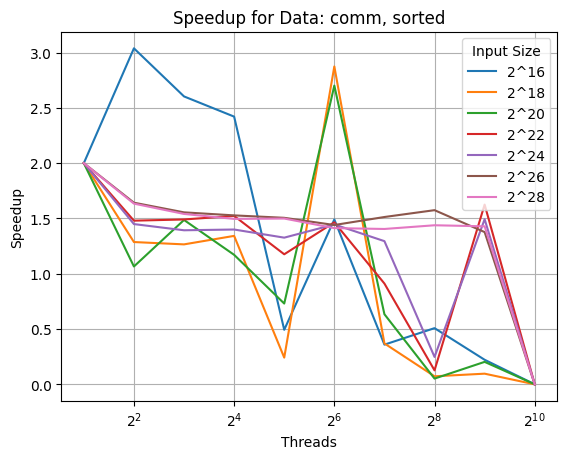

No data available for input size 65536 with 1024 processors, category 'comm', and data_type 'random'.
No data available for input size 262144 with 1024 processors, category 'comm', and data_type 'random'.
No data available for input size 1048576 with 1024 processors, category 'comm', and data_type 'random'.
No data available for input size 4194304 with 1024 processors, category 'comm', and data_type 'random'.
No data available for input size 16777216 with 1024 processors, category 'comm', and data_type 'random'.
No data available for input size 67108864 with 1024 processors, category 'comm', and data_type 'random'.
No data available for input size 268435456 with 1024 processors, category 'comm', and data_type 'random'.
Plot saved as speedup_plots/speedup_comm_data_type_random.png


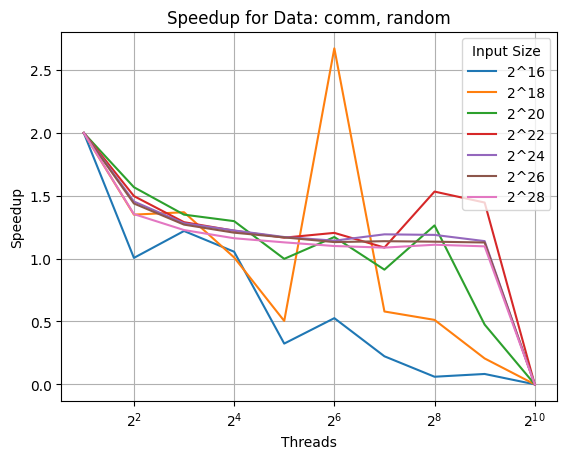

No data available for input size 65536 with 1024 processors, category 'comm', and data_type 'reverse_sorted'.
No data available for input size 262144 with 1024 processors, category 'comm', and data_type 'reverse_sorted'.
No data available for input size 1048576 with 1024 processors, category 'comm', and data_type 'reverse_sorted'.
No data available for input size 4194304 with 1024 processors, category 'comm', and data_type 'reverse_sorted'.
No data available for input size 16777216 with 1024 processors, category 'comm', and data_type 'reverse_sorted'.
No data available for input size 67108864 with 1024 processors, category 'comm', and data_type 'reverse_sorted'.
No data available for input size 268435456 with 1024 processors, category 'comm', and data_type 'reverse_sorted'.
Plot saved as speedup_plots/speedup_comm_data_type_reverse_sorted.png


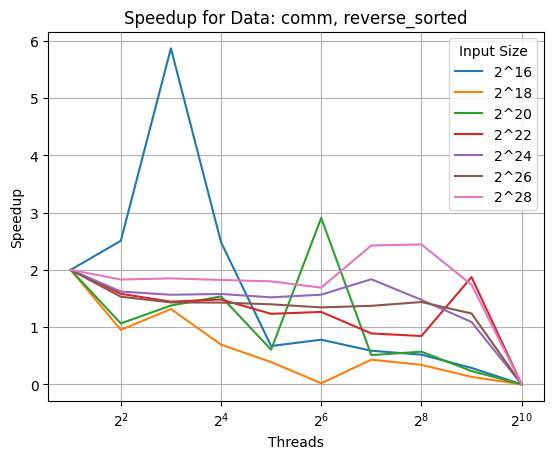

No data available for input size 65536 with 1024 processors, category 'comm', and data_type 'perturbed'.
No data available for input size 262144 with 1024 processors, category 'comm', and data_type 'perturbed'.
No data available for input size 1048576 with 1024 processors, category 'comm', and data_type 'perturbed'.
No data available for input size 4194304 with 1024 processors, category 'comm', and data_type 'perturbed'.
No data available for input size 16777216 with 1024 processors, category 'comm', and data_type 'perturbed'.
No data available for input size 67108864 with 1024 processors, category 'comm', and data_type 'perturbed'.
No data available for input size 268435456 with 1024 processors, category 'comm', and data_type 'perturbed'.
Plot saved as speedup_plots/speedup_comm_data_type_perturbed.png


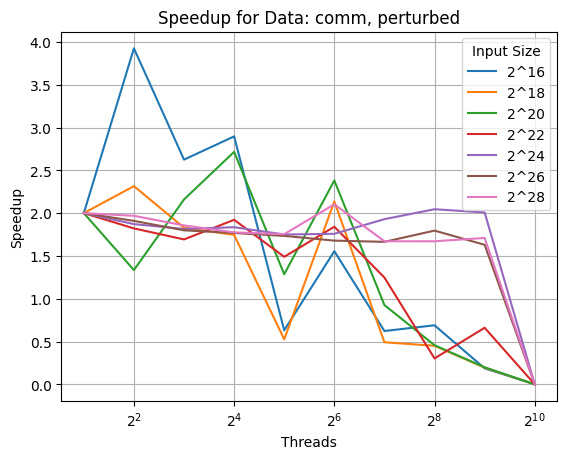

No data available for input size 65536 with 1024 processors, category 'comp', and data_type 'sorted'.
No data available for input size 262144 with 1024 processors, category 'comp', and data_type 'sorted'.
No data available for input size 1048576 with 1024 processors, category 'comp', and data_type 'sorted'.
No data available for input size 4194304 with 1024 processors, category 'comp', and data_type 'sorted'.
No data available for input size 16777216 with 1024 processors, category 'comp', and data_type 'sorted'.
No data available for input size 67108864 with 1024 processors, category 'comp', and data_type 'sorted'.
No data available for input size 268435456 with 1024 processors, category 'comp', and data_type 'sorted'.
Plot saved as speedup_plots/speedup_comp_data_type_sorted.png


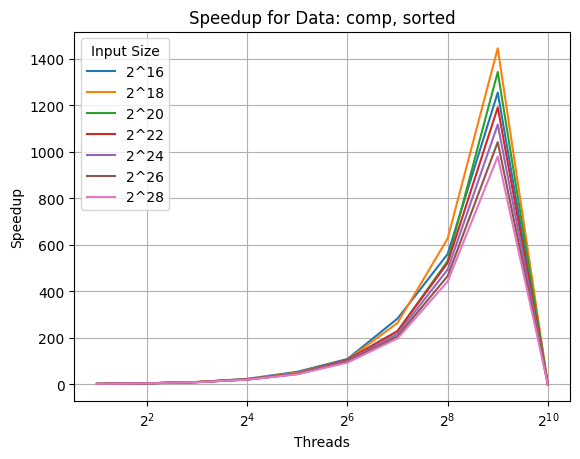

No data available for input size 65536 with 1024 processors, category 'comp', and data_type 'random'.
No data available for input size 262144 with 1024 processors, category 'comp', and data_type 'random'.
No data available for input size 1048576 with 1024 processors, category 'comp', and data_type 'random'.
No data available for input size 4194304 with 1024 processors, category 'comp', and data_type 'random'.
No data available for input size 16777216 with 1024 processors, category 'comp', and data_type 'random'.
No data available for input size 67108864 with 1024 processors, category 'comp', and data_type 'random'.
No data available for input size 268435456 with 1024 processors, category 'comp', and data_type 'random'.
Plot saved as speedup_plots/speedup_comp_data_type_random.png


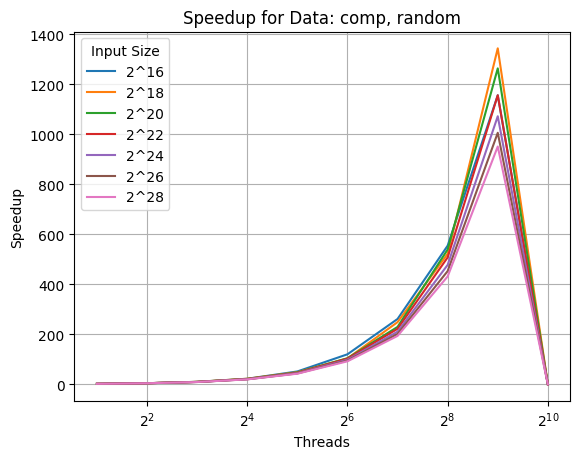

No data available for input size 65536 with 1024 processors, category 'comp', and data_type 'reverse_sorted'.
No data available for input size 262144 with 1024 processors, category 'comp', and data_type 'reverse_sorted'.
No data available for input size 1048576 with 1024 processors, category 'comp', and data_type 'reverse_sorted'.
No data available for input size 4194304 with 1024 processors, category 'comp', and data_type 'reverse_sorted'.
No data available for input size 16777216 with 1024 processors, category 'comp', and data_type 'reverse_sorted'.
No data available for input size 67108864 with 1024 processors, category 'comp', and data_type 'reverse_sorted'.
No data available for input size 268435456 with 1024 processors, category 'comp', and data_type 'reverse_sorted'.
Plot saved as speedup_plots/speedup_comp_data_type_reverse_sorted.png


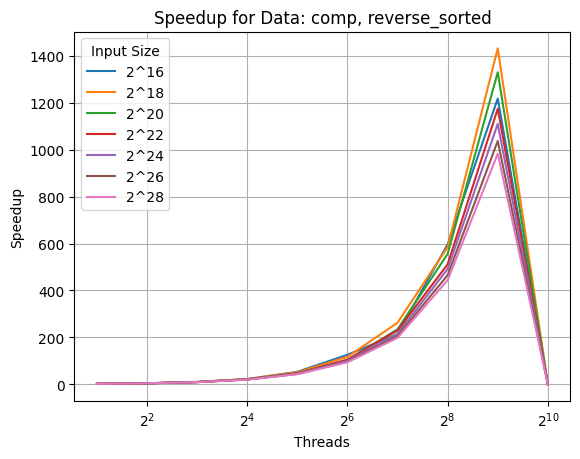

No data available for input size 65536 with 1024 processors, category 'comp', and data_type 'perturbed'.
No data available for input size 262144 with 1024 processors, category 'comp', and data_type 'perturbed'.
No data available for input size 1048576 with 1024 processors, category 'comp', and data_type 'perturbed'.
No data available for input size 4194304 with 1024 processors, category 'comp', and data_type 'perturbed'.
No data available for input size 16777216 with 1024 processors, category 'comp', and data_type 'perturbed'.
No data available for input size 67108864 with 1024 processors, category 'comp', and data_type 'perturbed'.
No data available for input size 268435456 with 1024 processors, category 'comp', and data_type 'perturbed'.
Plot saved as speedup_plots/speedup_comp_data_type_perturbed.png


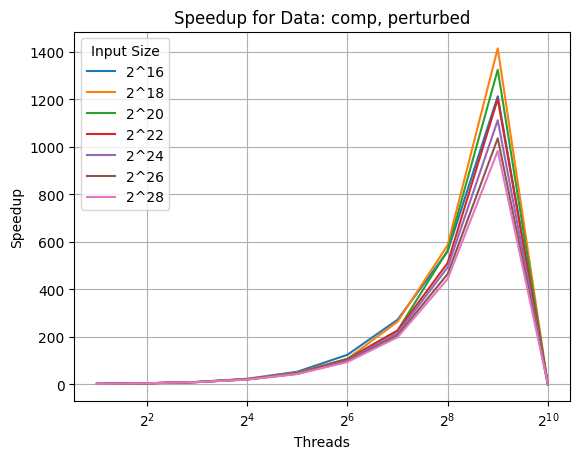

No data available for input size 65536 with 1024 processors, category 'main', and data_type 'sorted'.
No data available for input size 262144 with 1024 processors, category 'main', and data_type 'sorted'.
No data available for input size 1048576 with 1024 processors, category 'main', and data_type 'sorted'.
No data available for input size 4194304 with 1024 processors, category 'main', and data_type 'sorted'.
No data available for input size 16777216 with 1024 processors, category 'main', and data_type 'sorted'.
No data available for input size 67108864 with 1024 processors, category 'main', and data_type 'sorted'.
No data available for input size 268435456 with 1024 processors, category 'main', and data_type 'sorted'.
Plot saved as speedup_plots/speedup_main_data_type_sorted.png


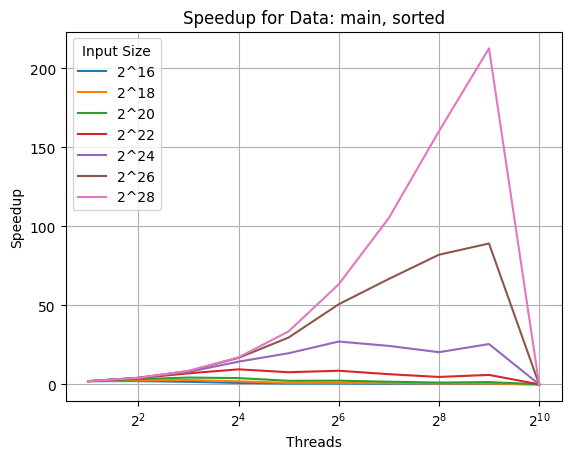

No data available for input size 65536 with 1024 processors, category 'main', and data_type 'random'.
No data available for input size 262144 with 1024 processors, category 'main', and data_type 'random'.
No data available for input size 1048576 with 1024 processors, category 'main', and data_type 'random'.
No data available for input size 4194304 with 1024 processors, category 'main', and data_type 'random'.
No data available for input size 16777216 with 1024 processors, category 'main', and data_type 'random'.
No data available for input size 67108864 with 1024 processors, category 'main', and data_type 'random'.
No data available for input size 268435456 with 1024 processors, category 'main', and data_type 'random'.
Plot saved as speedup_plots/speedup_main_data_type_random.png


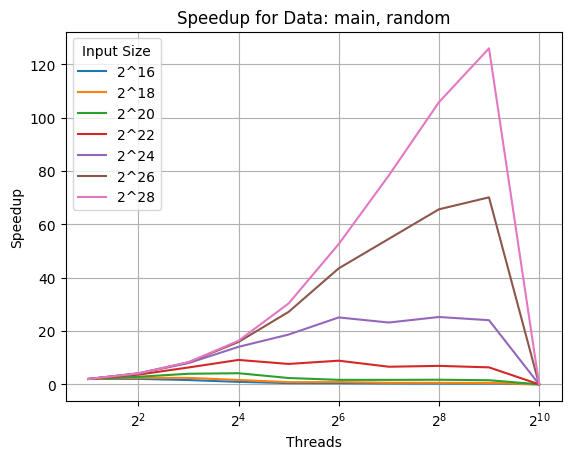

No data available for input size 65536 with 1024 processors, category 'main', and data_type 'reverse_sorted'.
No data available for input size 262144 with 1024 processors, category 'main', and data_type 'reverse_sorted'.
No data available for input size 1048576 with 1024 processors, category 'main', and data_type 'reverse_sorted'.
No data available for input size 4194304 with 1024 processors, category 'main', and data_type 'reverse_sorted'.
No data available for input size 16777216 with 1024 processors, category 'main', and data_type 'reverse_sorted'.
No data available for input size 67108864 with 1024 processors, category 'main', and data_type 'reverse_sorted'.
No data available for input size 268435456 with 1024 processors, category 'main', and data_type 'reverse_sorted'.
Plot saved as speedup_plots/speedup_main_data_type_reverse_sorted.png


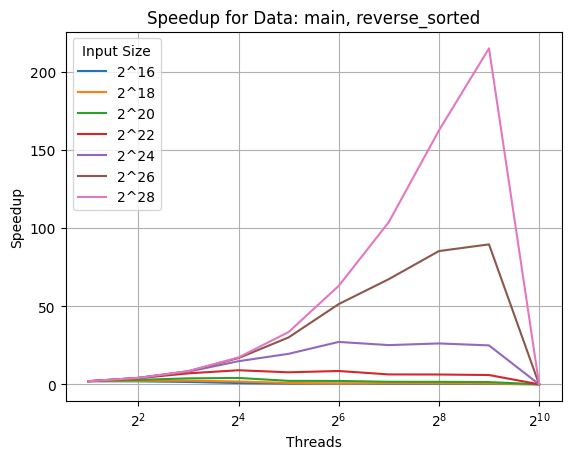

No data available for input size 65536 with 1024 processors, category 'main', and data_type 'perturbed'.
No data available for input size 262144 with 1024 processors, category 'main', and data_type 'perturbed'.
No data available for input size 1048576 with 1024 processors, category 'main', and data_type 'perturbed'.
No data available for input size 4194304 with 1024 processors, category 'main', and data_type 'perturbed'.
No data available for input size 16777216 with 1024 processors, category 'main', and data_type 'perturbed'.
No data available for input size 67108864 with 1024 processors, category 'main', and data_type 'perturbed'.
No data available for input size 268435456 with 1024 processors, category 'main', and data_type 'perturbed'.
Plot saved as speedup_plots/speedup_main_data_type_perturbed.png


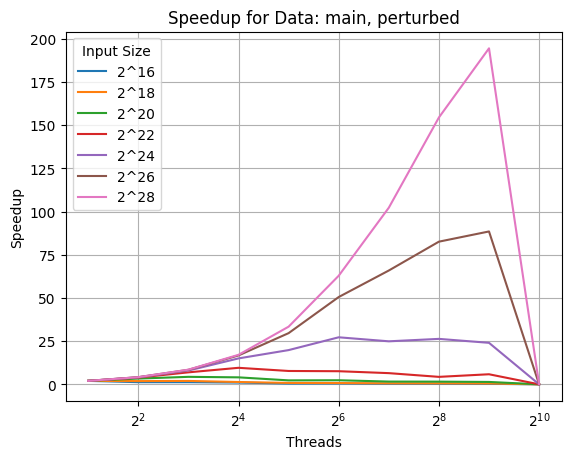

In [14]:
import os
import matplotlib.pyplot as plt

# Create the directory to save plots if it does not exist
output_dir = "speedup_plots"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define input sizes and thread counts (number of processes)
n_vals = [65536, 262144, 1048576, 4194304, 16777216, 67108864, 268435456]
thread_counts = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] # Replace with actual numbers of threads/ranks as needed
legends = ["2^16", "2^18", "2^20", "2^22", "2^24", "2^26", "2^28", "2^30"] # Legend labels for input sizes
data_types = ['sorted', 'random', 'reverse_sorted', 'perturbed'] # List of data types to filter
categories = ['comm', 'comp', 'main'] # Categories to loop through

# Loop through each category and each data type
for category in categories:
    for data_type in data_types:
        plt.figure() # Create a new figure for each category and data type
        plt.title(f"Speedup for Data: {category}, {data_type}") # Set the title for the plot

        # Loop through each input size to calculate and plot speedup
        for n_val, label in zip(n_vals, legends):
            # Filter the dataframe by input size, data type, and category
            df_filtered = tk.dataframe[(tk.dataframe['input_size'] == n_val) & 
                                       (tk.dataframe['input_type'] == data_type) & 
                                       (tk.dataframe['name'] == category)]

            # Extract baseline time for 2 threads/processes
            baseline_rows = df_filtered[df_filtered['num_procs'] == 2]
            if baseline_rows.empty:
                print(f"No baseline data available for input size {n_val} with 2 processors, category '{category}', and data_type '{data_type}'.")
                continue

            baseline_time = baseline_rows['Avg time/rank'].values[0]

            # Calculate speedup for each thread count
            speedup_values = []
            for threads in thread_counts:
                # Check if data for this number of threads exists
                thread_row = df_filtered[df_filtered['num_procs'] == threads]
                if not thread_row.empty:
                    time_for_threads = thread_row['Avg time/rank'].values[0]
                    speedup = 2 * baseline_time / time_for_threads
                    speedup_values.append(speedup)
                else:
                    speedup_values.append(0) # Set missing data to zero-speedup for continuity
                    print(f"No data available for input size {n_val} with {threads} processors, category '{category}', and data_type '{data_type}'.")

            # Plot speedup for current input size only if there are valid values
            if any(speedup_values):
                plt.plot(thread_counts, speedup_values, label=label)
            else:
                print(f"No valid speedup values found for input size {n_val}, category '{category}', data_type '{data_type}'.")

        # Configure plot settings
        plt.xscale("log", base=2) # Logarithmic scale for thread counts
        plt.xlabel("Threads")
        plt.ylabel("Speedup")
        plt.legend(title="Input Size")
        plt.grid(True) # Optional: add grid for better visibility

        # Save the plot as an image file in the specified output directory
        filename = f"{output_dir}/speedup_{category}_data_type_{data_type}.png"
        plt.savefig(filename)
        print(f"Plot saved as {filename}")

        plt.show()

        # Close the plot to save memory
        plt.close()